## **Install Pyspark and the required jdk** 


In [3]:
!pip install pyspark
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u342-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


## **Setting the Environment**

In [4]:
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

### **Authenticating the Google drive, to use files from google drive**

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Getting the required file from the google drive**

In [6]:
fileDownloaded=drive.CreateFile({'id':'1JGvKKGsxhlM3kY8BGsMSwfYLRGB47v56'})
fileDownloaded.GetContentFile('mini_spark_event_data.json')

## **Importing the necessary libraries & evaluation metrics for our models**

In [7]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



## **Creating a spark session which is the entry point of spark**

In [9]:
#create the session
spark=SparkSession.builder.appName("Soumee_Ghosh_2211444_Assignment_4").getOrCreate()

## **Loading and cleaning the dataset**

#### Loading and cleaning the dataset to check for missing values or invalid data

In [11]:
#loading the dataset
df="mini_spark_event_data.json"
#converting the dataset into a spark dataframe
df=spark.read.json(df)

In [15]:
#In Spark dataframef.show() is used to display the contents of the DataFrame in a Table Row & Column Format
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [16]:
# Cleaning the Dataset
df = df.drop(*['artist','song','firstName', 'lastName', 'id_copy'])             # dropping some irrelevant columns
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])                   # droppping some potential NA values
df = df.filter(df.userId!='').orderBy(["userId", "ts"], ascending=[True, True]) # filtering out the invalid Ids
df = df.withColumn("userId", df["userId"].cast(IntegerType()))                  # Casting UserId into an Integer datatype



**CHURN : Churn analytics is the process of measuring the rate at which customers quit the product, site, or service. It answers the questions “Are we losing customers?” and “If so, how?” to allow teams to take action. Lower churn rates lead to happier customers, larger margins, and higher profit**

In [17]:
# Defining the Churn
# These are Customers landing on the Cancellation Confirmation page
#PySpark UDF is a User Defined Function that is used to create a reusable function in Spark. 
#Once UDF created, that can be re-used on multiple DataFrames 
cancelation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, 
                  IntegerType())  
#here we are defining a function cancelation where when x= cancellation confirmed then x=1 else 0 i.e. we are converting into Integer type 

#.withColumn function in spark is a transformation function 
df = df.withColumn("churn", cancelation("page"))

#Window function is also a transformation function.
#PySpark Window function performs statistical operations such as rank, row number, etc. on a group, frame, 
# or collection of rows and returns results for each row individually. 
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, 
                                                   Window.unboundedFollowing)
#here we are using window function to partition the data by userId, 
# rangeBetween is used to specify both start and end are relative positions from the current row.


#returns a new column churn by replacing it with sum of churn values calculated by partitioning over userId using window function
df = df.withColumn("churn", Fsum("churn").over(window))



In [19]:
##Some new columns were made in this step to make the data exploration easier,
# the Feature engineering step comes later
# Making the level_shift Column
# This column tells us how many times did the customer switched
# from paid to free service
#using the window function 
window1 = Window.partitionBy().orderBy(["userId", "ts"])
df = df.withColumn("level_shift", (df.level!=F.lag(df.level).over(window1)) | 
                   (df.userId!=F.lag(df.userId).over(window1)))
#replacing the null values 
df=df.fillna({'level_shift':0})
df= df.withColumn("level_shift", F.when(df["level_shift"]==False, 0).otherwise(1))

In [20]:
# Making the last_ts column
# This column will help us to select only records that happened in the
# last 2 weeks of customer activity
# The idea is that customer behavior should be different shortly before
# the churn happened
df= df.withColumn("ts", df.ts/1000)                        # trimming the last three zeros from the UNIX time (miliseconds)
#replacing the existing column registrations with registrations/1000
df= df.withColumn("registration", df.registration/1000)

In [23]:
window2 = Window.partitionBy("userId")
df=df.withColumn("last_ts",F.max('ts').over(window))
#filtering rows using the given condition
df=df.filter(df.last_ts-df.ts < 1300000)  #approx no of sec in 2 weeks

In [24]:
# Making the Columns: pages_per_session, diff_time
# pages_per_session is number of pages per session
# diff_time is a number of days since a specific page was visited
#Using the window function to partition data by userid and sessionid
window3 = Window.partitionBy(["userId", "sessionId"])
df= df.withColumn("pages_per_session", F.max('ItemInSession').over(window3))
df = df.withColumn("ts_time",F.to_timestamp(df.ts))                    #  unix to datetime
df = df.withColumn("last_ts_time",F.to_timestamp(df.last_ts))          # unix to datetime

In [25]:
df = df.withColumn("diff_time",F.datediff(df.last_ts_time, df.ts_time))  # how many days ago was the page visited
df=df.orderBy(["userId", "ts"], ascending=[True, True])                   #ordering by userId and ts in ascending order
df.createOrReplaceTempView('data');                                    # Create a Temp Table i.e. a view to be used for SQL queries

In [26]:
#Data Preview
df.limit(2).toPandas()

,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,...,ts,userAgent,userId,churn,level_shift,last_ts,pages_per_session,ts_time,last_ts_time,diff_time
0,Logged In,F,0,286.40608,paid,"Raleigh, NC",PUT,NextSong,1536799.77,1,...,1538974.195,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1542839.404,443,1970-01-18 19:29:34.195,1970-01-18 20:33:59.404,0
1,Logged In,F,1,180.84526,paid,"Raleigh, NC",PUT,NextSong,1536799.77,1,...,1538974.481,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1542839.404,443,1970-01-18 19:29:34.481,1970-01-18 20:33:59.404,0


In [27]:
# The column "page" seems to be most informative in the whole dataset
# It shows which pages of the service were visited by users, timestamp is also provided
# This column can be used to engineer useful features
#using the group by function to group pages and showing the count of pages visited by users
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         63|
|         Thumbs Down|       2546|
|                Home|      10082|
|           Downgrade|       2055|
|         Roll Advert|       3933|
|              Logout|       3226|
|       Save Settings|        310|
|Cancellation Conf...|         52|
|               About|        495|
|            Settings|       1514|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Help|       1454|
|             Upgrade|        499|
|               Error|        252|
|      Submit Upgrade|        159|
+--------------------+-----------+



In [28]:
#Checking out the schema
df.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- churn: long (nullable = true)
 |-- level_shift: integer (nullable = false)
 |-- last_ts: double (nullable = true)
 |-- pages_per_session: long (nullable = true)
 |-- ts_time: timestamp (nullable = true)
 |-- last_ts_time: timestamp (nullable = true)
 |-- diff_time: integer (nullable = true)



In [29]:
# Investigation if there are differences between churned and non-churned users
# label             - 0 if non_churned, 1 if churned
# song_count        - avg number of songs played by churned/non_churned users
# error             - avg number of errors occuring 
# friends           - avg number of "friends" on thhe application
# playlist_count    - avg number of visits to the Playlist page
# thumbs_up         - avg number of clicking the 'thumbs up'
# thumbs_down       - avg number of clicking the 'thumbs down'
# downgrade         - avg number of visits to the downgrade page
# count_session_dist- avg number of sessions made
# count_diff_time   - avg number of days (in the last two weeks) in which the user used the app
# pages per session - avg numbers of pages (or any activity or changes) per session
# duration          - avg number of days since the user joined (division with 86400 as a proxy of seconds within a day)
# level_shift       - avg number of level changes (free, paid) per customer
# usage_time        - avg total time spent using the app
stats = spark.sql(" WITH prep as( \
SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
avg(distinct pages_per_session)                                     as pages_per_session, \
(max(ts) - min(registration))/86400                                 as duration, \
sum(level_shift)                                                    as level_shift, \
sum(length)                                                         as usage_time \
FROM data \
GROUP BY userId) \
SELECT label, \
count(label)             as cnt, \
avg(song_count)          as song_count, \
avg(error)               as error, \
avg(friends)             as friends, \
avg(playlist_count)      as playlist_count, \
avg(thumbs_up)           as thumbs_up, \
avg(thumbs_down)         as thumbs_down, \
avg(downgrade)           as downgrade, \
avg(count_session_dist)  as count_session_dist, \
avg(count_diff_time)     as count_diff_time, \
avg(pages_per_session)   as pages_per_session, \
avg(duration)            as duration, \
avg (level_shift)        as level_shift, \
avg(usage_time)          as usage_time \
FROM prep \
GROUP BY label")
# We can see that for most dimensions/features there are differences between
# churned and non-churned users
# we are convertiing the stats results into a pandas dataframe
stats.toPandas()



,label,cnt,song_count,error,friends,playlist_count,thumbs_up,thumbs_down,downgrade,count_session_dist,count_diff_time,pages_per_session,duration,level_shift,usage_time
0,0,173,1108.173410,1.271676,21.046243,31.722543,61.803468,11.849711,9.930636,15.254335,1.0,90.637949,0.086621,2.034682,276166.937468
1,1,52,699.884615,0.615385,12.230769,19.961538,35.750000,9.538462,6.480769,10.326923,1.0,80.108614,0.057306,1.788462,174014.268551


## **Feature Engineering**


In [31]:
 #Feature Enigneering
# Based on the previous analysis, all 14 investigated features will be included. 
# Here I am making a Temp Table which holds all the features.
# The temp table will be used as model input
# All data is aggregated per userId
features = spark.sql("SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
round(avg(distinct pages_per_session),0)                            as pages_per_session, \
round((max(ts) - min(registration))/86400,0)                        as duration, \
round(sum(level_shift),0)                                           as level_shift, \
round(sum(length),0)                                                as usage_time \
FROM data \
GROUP BY userId");
features.createOrReplaceTempView('features');
features=features.na.drop() #dropping the null values

## **Model Buuilding**

In [32]:
#Train test split using the .randomSplit function where train data=80% and test data=20%
training, test = features.randomSplit([0.8,0.2])

#### Vector Assembler : A feature transformer that merges multiple columns into a vector column. so that spark can read the data and perform the model building actions

In [33]:
# Make VectorAssembler - this is a Pypark specific step
# All input features must be in one column before feeding into the model

#Vector Assembler : A feature transformer that merges multiple columns into a vector column.
assembler = VectorAssembler(inputCols=["userId","song_count","error","friends","playlist_count", \
                                       "thumbs_up","thumbs_down","downgrade", "count_session_dist",\
                                       "count_diff_time","pages_per_session", "duration","level_shift",\
                                       "usage_time"], \
                            outputCol="inputFeatures")

#### Scaling the data

In [34]:
#Normalize Data i.e. scaling the data
scaler = Normalizer(inputCol = "inputFeatures",outputCol="features")

#### **Creating an instance for the models we are about to train**

In [35]:
lr = LogisticRegression() #Logistic Regression
gbt = GBTClassifier() #Gradient Boost Classifier
rf = RandomForestClassifier() #random Forest Classifier

### **Building Pipelines**
##### A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator.
##### Here we are specifying to first perform vector assembler, then scaling and then creating an instance for the model

In [36]:
#Building pipelines
#A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator

pipeline1 = Pipeline(stages=[assembler, scaler,lr]) 
pipeline2 = Pipeline(stages=[assembler, scaler,gbt])
pipeline3 = Pipeline(stages=[assembler, scaler,rf])

**Choosing F1 which is the harmonic mean of precision and recall is used as an evaluation metrics**

In [37]:
# metric chosen is f1 (we want to catch true positives (churn customers), but
# we do not want to waste money on false positives (investing in retaining 
# non-churn customers, which are loyal anyway)
# Note that Recall might also be justified to use here (if the cost offalse
# positives is low)
paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10])\ 
.build()

### **Evaluation using F1 score**
Unlike binary classification, multi-class classification generates an F-1 score for each class separately.

In [38]:
evaluator = MulticlassClassificationEvaluator(metricName="f1")

**ML tuning:Model selection & hyperparameter tuning**

In [39]:
crossval= CrossValidator(estimator=pipeline1,  #for the first model
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator , 
                         numFolds=3
                        )

#### **Fitting the training data**

In [40]:
cvModel1 = crossval.fit(training)

**Evaluating the model using the test data**

In [41]:
evaluator.evaluate(cvModel1.transform(test))

0.6472049689440995

### Similarly we follow the similar steps for training, testing and evaluating the model for other models

## **Gradient Boosted tree Classifier**

In [57]:
# Specify multiple parameters in the paramgrid, in case you have
# enough processing power 
paramgrid1 =ParamGridBuilder().build()

In [58]:
evaluator=MulticlassClassificationEvaluator(metricName="f1")

In [59]:
crossval= CrossValidator(estimator=pipeline2,  
                         estimatorParamMaps=paramgrid1,
                         evaluator=evaluator, 
                         numFolds=3
                        )

In [60]:
cvModel2 = crossval.fit(training)

In [61]:
evaluator.evaluate(cvModel2.transform(test))

0.6526961410682341

## **Random Forest Classifier**

In [52]:
paramgrid2 = ParamGridBuilder().build()

In [53]:
evaluator=MulticlassClassificationEvaluator(metricName="f1")

In [54]:
crossval = CrossValidator(estimator=pipeline3,
                          estimatorParamMaps=paramgrid2,
                          evaluator=evaluator,
                          numFolds=3
                          )

In [55]:
cvModel3 = crossval.fit(training)

In [56]:
evaluator.evaluate(cvModel3.transform(test))

0.6592287169536745

In [62]:
predictions=cvModel2.transform(test)

### Thus we can conclude that in terms of performance Radom Classifier model > Gradient Boosting Classifier model > Logistic model.

### **Plotting the ROC curve for the 3rd model**
#### An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate. False Positive Rate.

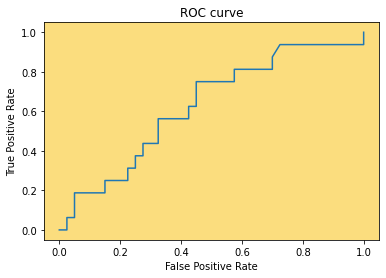

In [63]:
def roc(ax, predictions, labels, title='ROC curve'):
    pp = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    tpr, fpr, _ = roc_curve(labels, pp)
    ax.plot(tpr, fpr)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    
#plt.clf() # to be used for AWS EMR
labels=predictions.toPandas()['label']
fig = plt.figure()
ax = fig.add_subplot(111)
roc(ax, predictions,labels)